# Task 5

This notebook implements the evaluation and repair of quantum-optimized bond portfolio selections (QAOA and VQE) against a benchmark classical model with hard constraints. The workflow is:

1. Load Benchmark Model

- Read the classical LP formulation (docplex model) representing the hard-constraint portfolio optimization problem.

- Solve it to obtain the classical optimum as a baseline for comparison.

2. Load Quantum Outputs

- Import QAOA and VQE result files (bitstrings or selection masks) produced from the QUBO formulation.

- Convert bitstrings into bond selection masks consistent with the benchmark model.

3. Evaluate Feasibility & Objective

- For each selection, compute the objective value and check constraint violations under the benchmark model.

- Record feasibility and list violated constraints with details.

4. Repair Infeasible Solutions

- If infeasible, run repair heuristics:

- Identify worst selected and best unselected bonds (pick_worst_selected, _rank).

- Swap bonds to reduce violations (repair_to_feasible).

- Re-evaluate until feasible or no improvement possible.

5. Compare Solutions

- Compare repaired and unrepaired QAOA/VQE results against the classical optimum in terms of:

- Objective value

- Feasibility

- Constraint violation profiles

- Include both full-universe and reduced-universe (MAX_BONDS) cases.

6. Output & Logging

- Print concise summaries of each method’s selection, feasibility, and objective.

- Save JSON masks for reproducibility and further analysis.

In [1]:
from typing import Dict, Optional, Tuple, List, Union
import json
import pandas as pd
from docplex.mp.model_reader import ModelReader
from docplex.mp.model import Model
from docplex.mp.solution import SolveSolution
import math
from datetime import datetime
import copy


In [2]:
def read_model(lp_path: str) -> Model:
    """Load a .lp/.sav model with DOcplex reader."""
    return ModelReader.read(lp_path)

def solve_model(mdl: Model, time_limit: Optional[float] = None, log_output: bool = False) -> Optional[SolveSolution]:
    """Solve a DOcplex model. Returns None if infeasible or not solved."""
    if time_limit is not None:
        mdl.context.cplex_parameters.timelimit = time_limit
    return mdl.solve(log_output=log_output)

def solution_stats(mdl: Model, sol: Optional[SolveSolution]) -> dict:
    """Collect consistent stats for display/comparison."""
    if sol is None:
        return {
            "status": mdl.solve_details.status,
            "status_code": mdl.solve_details.status_code,
            "solved": False,
            "objective": None,
            "best_bound": None,
            "mip_gap": None,
            "active_binaries": None,
            "num_binary_vars": mdl.number_of_binary_variables,
            "num_vars": mdl.number_of_variables,
            "num_constraints": mdl.number_of_constraints,
        }
    bin_vars = list(mdl.iter_binary_vars())
    active = sum(1 for v in bin_vars if sol.get_value(v) > 0.5)
    return {
        "status": mdl.solve_details.status,
        "status_code": mdl.solve_details.status_code,
        "solved": True,
        "objective": mdl.objective_value,
        "best_bound": mdl.solve_details.best_bound,
        "mip_gap": mdl.solve_details.mip_relative_gap, 
        "active_binaries": active,
        "num_binary_vars": len(bin_vars),
        "num_vars": mdl.number_of_variables,
        "num_constraints": mdl.number_of_constraints,
    }


In [3]:
def fix_assignment_and_score(
    mdl: Model,
    assignment: Dict[str, Union[int, float]],
    log_output: bool = False,
    time_limit: Optional[float] = None,
) -> Tuple[Optional[SolveSolution], float]:
    
    original_bounds = {}
    for name, val in assignment.items():
        v = mdl.get_var_by_name(name)
        if v is None:
            continue
        original_bounds[name] = (v.lb, v.ub)
        v.lb = v.ub = float(val)

    try:
        if time_limit is not None:
            mdl.context.cplex_parameters.timelimit = time_limit
        sol = mdl.solve(log_output=log_output)
        if sol is None:
            return None, float("nan")
        return sol, mdl.objective_value
    finally:
        for name, (lb, ub) in original_bounds.items():
            v = mdl.get_var_by_name(name)
            if v is not None:
                v.lb, v.ub = lb, ub


In [4]:
def evaluate_lp_files(
    lp_files: List[str],
    time_limit: Optional[float] = None,
    eval_bitstring: Optional[Dict[str, Union[int, float]]] = None,
    only_eval: bool = False,
    log_output: bool = False,
) -> pd.DataFrame:
    """
    Evaluate one or more LP/QP files classically and (optionally) score a fixed assignment.

    lp_files: list of paths to .lp files (Docplex format from benchmark / QAOA / VQE).
    eval_bitstring: optional mapping {var_name: 0/1} to evaluate under each model.
    only_eval: if True, skip classical optimum and only score the provided assignment.

    Returns: pandas DataFrame with one row per file.
    """
    rows = []
    for lp in lp_files:
        rec = {"file": lp}
        try:
            mdl = read_model(lp)

            if not only_eval:
                sol = solve_model(mdl, time_limit=time_limit, log_output=log_output)
                stats = solution_stats(mdl, sol)
                rec.update({
                    "status": stats["status"],
                    "solved": stats["solved"],
                    "classical_objective": stats["objective"],
                    "gap": stats["mip_gap"],
                    "active_binaries": stats["active_binaries"],
                    "num_binary_vars": stats["num_binary_vars"],
                    "num_constraints": stats["num_constraints"],
                })
            else:
                rec.update({
                    "status": "SKIPPED (only-eval)",
                    "solved": None,
                    "classical_objective": None,
                    "gap": None,
                    "active_binaries": None,
                    "num_binary_vars": mdl.number_of_binary_variables,
                    "num_constraints": mdl.number_of_constraints,
                })

            if eval_bitstring is not None:
                sol_fixed, obj_fixed = fix_assignment_and_score(
                    mdl, eval_bitstring, log_output=log_output, time_limit=time_limit
                )
                rec.update({
                    "eval_bitstring_objective": obj_fixed,
                    "eval_bitstring_feasible": sol_fixed is not None
                })

        except Exception as e:
            rec = {"file": lp, "error": repr(e)}

        rows.append(rec)

    def _rank(name: str) -> int:
        n = (name or "").lower()
        return 0 if ("bench" in n or "docplex" in n) else 1

    rows.sort(key=lambda r: _rank(r.get("file", "")))
    df = pd.DataFrame(rows)
    return df


In [5]:
def load_bitstring_json(path: str) -> Dict[str, Union[int, float]]:
    with open(path, "r") as f:
        return json.load(f)


In [6]:
lp_files = [
    "../WISER_Optimization_VG/data/1/31bonds/docplex.lp",
    "quantum_penalized_qaoa.lp",
    "quantum_penalized_vqe.lp",
]


In [7]:

bit_map = load_bitstring_json("qaoa_mask_20250809-225222.json")  


In [8]:


bench_lp = "../WISER_Optimization_VG/data/1/31bonds/docplex.lp"
mdl_bench: Model = ModelReader.read(bench_lp)

# Solve once for the classical routine
sol_opt = mdl_bench.solve(log_output=False)
opt_val = mdl_bench.objective_value if sol_opt is not None else float("nan")
print("Benchmark classical optimum:", opt_val)

Benchmark classical optimum: 40.260003713135546


In [10]:
def eval_mask_under_benchmark(mdl: Model, mask: dict, time_limit=None, log_output=False):
    """
    Fixes binaries per mask (var name -> 0/1), re-solves quickly, returns (feasible, objective).
    Restores original bounds afterward.
    """
    original_bounds = {}
    for name, val in mask.items():
        v = mdl.get_var_by_name(name)
        if v is None: 
            continue
        original_bounds[name] = (v.lb, v.ub)
        v.lb = v.ub = float(val)

    try:
        if time_limit is not None:
            mdl.context.cplex_parameters.timelimit = time_limit
        sol = mdl.solve(log_output=log_output)
        if sol is None:
            return False, math.nan
        return True, mdl.objective_value
    finally:
        for name, (lb, ub) in original_bounds.items():
            v = mdl.get_var_by_name(name)
            if v is not None:
                v.lb, v.ub = lb, ub


In [11]:
qaoa_mask = load_bitstring_json("qaoa_mask_20250809-225222.json")
vqe_mask = load_bitstring_json("vqe_mask_20250809-225222.json")

q_feas, q_obj = eval_mask_under_benchmark(mdl_bench, qaoa_mask, time_limit=None)
print("QAOA -> feasible:", q_feas, " objective:", q_obj, " gap%:", (q_obj - opt_val)/abs(opt_val)*100 if q_feas and sol_opt else None)

if vqe_mask:
    v_feas, v_obj = eval_mask_under_benchmark(mdl_bench, vqe_mask, time_limit=None)
    print("VQE  -> feasible:", v_feas, " objective:", v_obj, " gap%:", (v_obj - opt_val)/abs(opt_val)*100 if v_feas and sol_opt else None)


QAOA -> feasible: False  objective: nan  gap%: None
VQE  -> feasible: False  objective: nan  gap%: None


In [ ]:
def summarize_selection(mask: Dict[str,int], bonds: List[dict]) -> Dict[str, Dict[str, float]]:
    """Return sector sums for PMV and DXS based on current selection."""
    sums = {}
    for b in bonds:
        if mask.get(f"x_{b['id']}", 0) != 1:
            continue
        s = b['sector']
        d = sums.setdefault(s, {"pmv":0.0, "dxs":0.0, "count":0})
        d["pmv"] += float(b["pmv"])
        d["dxs"] += float(b["dxs"])
        d["count"] += 1
    return sums

def feasibility_violations(mask: Dict[str,int], bonds: List[dict], sector_data: dict) -> List[Tuple[str,str,float,float]]:
    """
    Return a list of (sector, kind, value, required) for each violated constraint.
    kind in {"pmv_min","pmv_max","dxs_min","dxs_max"}.
    """
    sums = summarize_selection(mask, bonds)
    viols = []
    for sector, bands in sector_data.items():
        pmv = sums.get(sector, {}).get("pmv", 0.0)
        dxs = sums.get(sector, {}).get("dxs", 0.0)
        pmn = bands.get("pmv_min", None)
        pmx = bands.get("pmv_max", None)
        dmn = bands.get("dxs_min", None)
        dmx = bands.get("dxs_max", None)

        if pmn is not None and pmn != 0 and pmv < pmn:
            viols.append((sector, "pmv_min", pmv, pmn))
        if pmx is not None and pmx != 0 and pmv > pmx:
            viols.append((sector, "pmv_max", pmv, pmx))
        if dmn is not None and dxs < dmn:
            viols.append((sector, "dxs_min", dxs, dmn))
        if dmx is not None and dxs > dmx:
            viols.append((sector, "dxs_max", dxs, dmx))
    return viols

def pick_best_unselected(bonds: List[dict], mask: Dict[str,int], sector: Optional[str], score_key: str) -> Optional[str]:
    """
    Choose the unselected bond (optionally within a sector) maximizing pmv or dxs (score_key).
    Returns var name 'x_<id>' or None.
    """
    best = None
    best_score = -1e99
    for b in bonds:
        if sector is not None and b['sector'] != sector:
            continue
        var = f"x_{b['id']}"
        if mask.get(var,0) == 1:
            continue
        s = float(b[score_key])
        if s > best_score:
            best_score = s
            best = var
    return best

def pick_worst_selected(bonds: List[dict], mask: Dict[str,int], sector: Optional[str], score_key: str) -> Optional[str]:
    """
    Choose the selected bond (optionally within a sector) with the largest score (to remove for dxs_max),
    or smallest score (to remove for pmv trimming ) — here used largest when reducing dxs
    """
    worst = None
    worst_score = -1e99
    for b in bonds:
        if sector is not None and b['sector'] != sector:
            continue
        var = f"x_{b['id']}"
        if mask.get(var,0) != 1:
            continue
        s = float(b[score_key])
        if s > worst_score:
            worst_score = s
            worst = var
    return worst

def current_count(mask: Dict[str,int]) -> int:
    return sum(1 for v in mask.values() if v==1)


In [13]:
def repair_to_feasible(
    start_mask: Dict[str,int],
    bonds: List[dict],
    sector_data: dict,
    target_count: Optional[int] = None,
    max_iters: int = 500
) -> Dict[str,int]:
    """
    Greedy repair:
      1) Satisfy sector PMV_min by adding highest-PMV bonds in that sector.
      2) Satisfy sector DXS_min by adding highest-DXS bonds in that sector.
      3) Satisfy sector DXS_max by removing highest-DXS bonds in that sector.
      4) If target_count given, adjust count by adding/removing neutral choices.
    Returns a repaired mask (copy).
    """
    mask = copy.deepcopy(start_mask)

    # Make sure all bonds in metadata exist in mask (default 0) so count checks work
    for b in bonds:
        mask.setdefault(f"x_{b['id']}", 0)

    it = 0
    while it < max_iters:
        it += 1
        viols = feasibility_violations(mask, bonds, sector_data)
        if not viols:
            break  # all sector constraints met

        # Prioritize PMV_min, then DXS_min, then DXS_max
        handled = False
        # 1) Fix PMV mins
        for (sector, kind, val, req) in viols:
            if kind == "pmv_min":
                var = pick_best_unselected(bonds, mask, sector, "pmv")
                if var is None:
                    return mask
                mask[var] = 1
                handled = True
                break
        if handled: 
            continue

        # 2) Fix DXS mins
        for (sector, kind, val, req) in viols:
            if kind == "dxs_min":
                var = pick_best_unselected(bonds, mask, sector, "dxs")
                if var is None:
                    return mask
                mask[var] = 1
                handled = True
                break
        if handled:
            continue

        # 3) Fix DXS max (remove largest DXS in that sector)
        for (sector, kind, val, req) in viols:
            if kind == "dxs_max":
                var = pick_worst_selected(bonds, mask, sector, "dxs")
                if var is None:
                    return mask
                mask[var] = 0
                handled = True
                break
        if handled:
            continue
        break

    if target_count is not None:
        cnt = current_count(mask)
        while cnt < target_count and it < max_iters:
            it += 1
            best = None
            best_score = -1e99
            for b in bonds:
                var = f"x_{b['id']}"
                if mask.get(var,0)==1:
                    continue
                score = float(b['pmv']) + float(b['dxs'])
                if score > best_score:
                    best_score = score
                    best = var
            if best is None:
                break
            mask[best] = 1
            cnt += 1

        while cnt > target_count and it < max_iters:
            it += 1
            worst = None
            worst_score = 1e99
            for b in bonds:
                var = f"x_{b['id']}"
                if mask.get(var,0)!=1:
                    continue
                score = float(b['pmv']) + float(b['dxs'])
                if score < worst_score:
                    worst_score = score
                    worst = var
            if worst is None:
                break
            mask[worst] = 0
            cnt -= 1

    return mask


In [14]:
json_path = '../bond_data.json'

with open(json_path, 'r') as f:
     data = json.load(f)

bonds = data['bonds']
sector_data = data['sector_data']

# Example: target 19 bonds like the benchmark
repaired_qaoa = repair_to_feasible(qaoa_mask, bonds, sector_data, target_count=19)

# 2) Evaluate under the benchmark (hard constraints & objective)
q_feas, q_obj = eval_mask_under_benchmark(mdl_bench, repaired_qaoa)
print("Repaired QAOA -> feasible:", q_feas, "objective:", q_obj)

print("Violations before repair:", feasibility_violations(qaoa_mask, bonds, sector_data))




Repaired QAOA -> feasible: False objective: nan
Violations before repair: [('Capital_Goods', 'pmv_min', 0.096208698925, 4.758736462913), ('Capital_Goods', 'dxs_min', 35.883786864551, 1780.68926045072), ('Insurance', 'pmv_min', 0.065358410114, 4.134392251914), ('Insurance', 'dxs_min', 49.96530736448, 1991.42972820855), ('Transportation', 'pmv_min', 0.027884438059, 0.240014083139)]


In [ ]:
"""
sector-level floors under the benchmark (hard-constraint) evaluator.
violoation above causes include:
  1) Penalty weights (λ) for sector constraints too small in the QUBO, making them
     effectively "soft" so QAOA trades off violations for objective gains.
  2) Unit/scaling mismatches between QUBO (normalized terms) and evaluator (absolute totals).
  3) Fixed mid-quantity sizing after selection that may be insufficient to reach sector floors.
  4) Infeasibility from MAX_BONDS/universe restrictions or per-bond inventory limits.
To reduce violations:
  - Increase λ for sector constraints and align units with evaluator.
  - Add structural guards (e.g., per-sector min cardinality).
  - Run a feasibility LP on the current universe before QAOA.
  - Optionally post-process QAOA selections with a sizing LP ("repair").
"""


def to_itrade_mask(xmask: dict) -> dict:
    """Convert {'x_<id>': 0/1} to {'iTrade_<id>': 0/1}."""
    out = {}
    for k, v in xmask.items():
        if k.startswith("x_"):
            out["iTrade_" + k[2:]] = int(v)
        else:
            out[k] = int(v)
    return out

def eval_itrade_mask_under_benchmark(mdl, xmask_or_itrade_mask, time_limit=None, log_output=False):
    """
    Fix only the binary iTrade_* variables per mask (0/1). Leave x_* free.
    Returns (feasible, objective).
    """

    name_to_var = {v.name: v for v in mdl.iter_variables()}
    # If the provided mask is x_*, convert to iTrade_*
    if any(k.startswith("x_") for k in xmask_or_itrade_mask):
        mask = to_itrade_mask(xmask_or_itrade_mask)
    else:
        mask = dict(xmask_or_itrade_mask)

    # Fix only binaries; skip continuous vars
    original_bounds = {}
    for name, val in mask.items():
        v = name_to_var.get(name)
        if v is None:
            continue

        if hasattr(v.vartype, "is_binary") and v.vartype.is_binary():
            original_bounds[name] = (v.lb, v.ub)
            v.lb = v.ub = float(val)

    try:
        if time_limit is not None:
            mdl.context.cplex_parameters.timelimit = time_limit
        sol = mdl.solve(log_output=log_output)
        if sol is None:
            return False, float("nan")
        return True, mdl.objective_value
    finally:
        for name, (lb, ub) in original_bounds.items():
            v = name_to_var.get(name)
            if v is not None:
                v.lb, v.ub = lb, ub


In [16]:

q_feas, q_obj = eval_itrade_mask_under_benchmark(mdl_bench, qaoa_mask)
print("QAOA (fix iTrade only) -> feasible:", q_feas, "objective:", q_obj)


QAOA (fix iTrade only) -> feasible: True objective: 40.260003713135546


In [17]:
#  Evaluate VQE under the benchmark
v_feas, v_obj = eval_itrade_mask_under_benchmark(mdl_bench, vqe_mask, time_limit=None, log_output=False)
print("VQE -> feasible:", v_feas, "objective:", v_obj)


VQE -> feasible: True objective: 40.260003713135546


In [ ]:
def save_masks(label, mask):
    """
    Saves two JSONs:
      - <label>_mask.json              (whatever keys was passed: x_* or iTrade_*)
      - <label>_iTrade_mask.json       (forced to iTrade_* binaries)
    Returns the file paths.
    """
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    # as-is
    as_is_path = f"{label}_mask_{ts}.json"
    with open(as_is_path, "w") as f:
        json.dump(mask, f, indent=2)
    # iTrade version
    itrade_mask = to_itrade_mask(mask) if any(k.startswith("x_") for k in mask) else dict(mask)
    itrade_path = f"{label}_iTrade_mask_{ts}.json"
    with open(itrade_path, "w") as f:
        json.dump(itrade_mask, f, indent=2)
    return as_is_path, itrade_path

qaoa_as_is, qaoa_itrade = save_masks("qaoa", qaoa_mask)
print("Saved:", qaoa_as_is, "and", qaoa_itrade)

vqe_as_is, vqe_itrade = save_masks("vqe", vqe_mask)
print("Saved:", vqe_as_is, "and", vqe_itrade)

Saved: qaoa_mask_20250810-154943.json and qaoa_iTrade_mask_20250810-154943.json
Saved: vqe_mask_20250810-154943.json and vqe_iTrade_mask_20250810-154943.json


In [ ]:

mdl_bench_full = read_model(bench_lp)  # define bench_lp_path earlier
all_vars = [v.name for v in mdl_bench_full.iter_variables()]  # all vars, not just binaries
i_names  = sorted([nm for nm in all_vars if nm.startswith("iTrade_")])
x_names  = sorted([nm for nm in all_vars if nm.startswith("x_")])

import pandas as pd, numpy as np

path = "../WISER_Optimization_VG/data/1/data_assets_dump_partial.xlsx"
df = pd.read_excel(path, engine="openpyxl")

# case-insensitive column picks
cmap = {c.strip().lower(): c for c in df.columns}
id_col  = cmap.get("securitymaster.cusip")          # bond data ID
bkt_col = cmap.get("sodraw.filterlevel2")           # bond data bucket

if id_col is None:
    raise KeyError("securityMaster.cusip not found. Have: %r" % list(df.columns))
if bkt_col is None:
    raise KeyError("sodraw.filterLevel2 not found. Have: %r" % list(df.columns))

# build x_<CUSIP> keys (clean + preserve 9 chars)
cusip_clean = (df[id_col].astype(str).str.upper()
               .str.replace(r"[^0-9A-Z]", "", regex=True)
               .str.zfill(9))
df["var_name"] = "x_" + cusip_clean

# map bucket labels -> ints 0..L-1
labels = {s: i for i, s in enumerate(sorted(df[bkt_col].astype(str).str.strip().unique()))}
mapping = dict(zip(df["var_name"], df[bkt_col].astype(str).str.strip().map(labels)))

bucket_of = np.array([mapping.get(nm, 0) for nm in x_names], dtype=int)
L = int(bucket_of.max()) + 1

print("Buckets (L):", L, "| unmatched x_*:", sum(nm not in mapping for nm in x_names))


Buckets (L): 3 | unmatched x_*: 0


In [ ]:
import time, numpy as np, pandas as pd
rng = np.random.default_rng(42)

def stratified_subset(bucket_of, k):
    idx = np.arange(len(bucket_of))
    chosen = []
    for b in np.unique(bucket_of):
        pool = idx[bucket_of == b]
        take = max(1, round(k * len(pool) / len(idx)))
        chosen.extend(rng.choice(pool, size=min(take, len(pool)), replace=False))
    # Trim/pad to exact k
    chosen = np.array(chosen)[:k]
    if len(chosen) < k:
        extra = np.setdiff1d(idx, chosen)
        chosen = np.concatenate([chosen, rng.choice(extra, size=k-len(chosen), replace=False)])
    return np.sort(chosen)

def restrict_model_to_subset(mdl, names_all, names_keep):
  
    keep = set(names_keep)
    for nm in names_all:
        if nm not in keep:
            if nm in mdl._vars_by_name:
                v = mdl._vars_by_name[nm]
                v.ub = 0.0
    return mdl

def run_classical(mdl):
    t0 = time.perf_counter()
    sol = solve_model(mdl, time_limit=300, log_output=False)
    t1 = time.perf_counter()
    stats = solution_stats(mdl, sol)
    return {
        "objective": stats.get("objective"),
        "feasible": stats.get("status") == "optimal",
        "time_sec": t1 - t0,
        "mip_gap": getattr(mdl.solve_details, "mip_relative_gap", None),
        "nodes": getattr(mdl.solve_details, "nb_nodes_processed", None),
    }

def eval_mask(mdl, mask):

    feas, obj = eval_itrade_mask_under_benchmark(mdl, mask, time_limit=120, log_output=False)
    return {"objective": obj, "feasible": bool(feas)}


import numpy as np
rng = np.random.default_rng(42)

def stratified_subset(bucket_of, k):
    idx = np.arange(len(bucket_of))
    k = min(k, len(idx))  # hard cap

    counts = np.bincount(bucket_of, minlength=bucket_of.max()+1)
    probs = counts / counts.sum()
    quotas = np.floor(probs * k).astype(int)
    rem = k - quotas.sum()
    remainders = (probs * k) - quotas
    for b in np.argsort(remainders)[::-1][:rem]:
        quotas[b] += 1

    chosen = []
    for b, q in enumerate(quotas):
        if q == 0: 
            continue
        pool = idx[bucket_of == b]
        take = min(q, len(pool))
        if take > 0:
            chosen.extend(rng.choice(pool, size=take, replace=False))

    chosen = np.array(chosen)
    if len(chosen) > k:
        chosen = chosen[:k]
    elif len(chosen) < k:
        # pad from remaining indices (will exist because k <= N)
        extra = np.setdiff1d(idx, chosen, assume_unique=False)
        chosen = np.concatenate([chosen, rng.choice(extra, size=k-len(chosen), replace=False)])
    return np.sort(chosen)

sizes = [15, 19, 25, 31]
rows = []
for n in sizes:
    subset_idx = stratified_subset(bucket_of, n)
    names_keep = [f"x_{i}" for i in subset_idx] + [f"iTrade_{i}" for i in subset_idx]

    mdl_bench_full = read_model(bench_lp)
    mdl_bench = restrict_model_to_subset(mdl_bench_full, list(mdl_bench_full._vars_by_name.keys()), names_keep)
    base = run_classical(mdl_bench)

    qaoa_mask = load_bitstring_json(f"qaoa_mask_20250810-154943.json") 
    vqe_mask  = load_bitstring_json(f"vqe_mask_20250810-154943.json")

    qaoa = eval_mask(mdl_bench, qaoa_mask)
    vqe  = eval_mask(mdl_bench, vqe_mask)

    for meth, res in [("Classical", base), ("QAOA", qaoa), ("VQE", vqe)]:
        rows.append({
            "n": n,
            "method": meth,
            "objective": res["objective"],
            "feasible": res["feasible"],
            "time_sec": res.get("time_sec"),
            "mip_gap": res.get("mip_gap"),
            "nodes": res.get("nodes"),
            "gap_vs_classical": None if meth=="Classical" or base["objective"] in (None, np.nan)
                                 else (res["objective"] - base["objective"]) / abs(base["objective"])
        })
df = pd.DataFrame(rows)


In [25]:
df.head()

,n,method,objective,feasible,time_sec,mip_gap,nodes,gap_vs_classical
0,15,Classical,NaN,False,0.007798,NaN,0.0,None
1,15,QAOA,NaN,False,NaN,NaN,NaN,None
2,15,VQE,NaN,False,NaN,NaN,NaN,None
3,19,Classical,NaN,False,0.006010,NaN,0.0,None
4,19,QAOA,NaN,False,NaN,NaN,NaN,None


In [26]:
bench = evaluate_lp_files([bench_lp], only_eval=False)  # classical baseline


q_eval = evaluate_lp_files([bench_lp], eval_bitstring=qaoa_mask, only_eval=True)
v_eval = evaluate_lp_files([bench_lp], eval_bitstring=vqe_mask,  only_eval=True)

rows = []

def row(method, df):
    obj = df.loc[0, "eval_bitstring_objective"]
    feas = bool(df.loc[0, "eval_bitstring_feasible"])
    
    return {"method": method, "objective": obj, "feasible": feas}

rows.append(row("QAOA", q_eval))
rows.append(row("VQE",  v_eval))

report = pd.DataFrame(rows)


In [27]:
def add_cardinality_cap(mdl, n):
    ivars = [v for v in mdl.iter_binary_vars() if v.name.startswith("iTrade_")]
    mdl.add_constraint(mdl.sum(ivars) <= n, ctname=f"cardinality_le_{n}")
    return mdl

def shrink_mask_to_k(mdl_path, mask_full, k, time_limit=60):
    """
    Greedy: repeatedly remove the single selected name whose removal hurts the objective least.
    Assumes mask_full fixes iTrade_* ∈ {0,1}. Returns a new mask with exactly k ones.
    """
    # work on a copy
    pick = {k:v for k,v in mask_full.items() if k.startswith("iTrade_")}
    ones = [nm for nm,v in pick.items() if v==1]
    if len(ones) <= k:
        return mask_full  # already ≤ k

    while len([nm for nm,v in pick.items() if v==1]) > k:
        best_nm, best_obj = None, None

        for nm in list(ones):
            trial = dict(pick)
            trial[nm] = 0
            mdl = read_model(mdl_path)

            add_cardinality_cap(mdl, k)
            feas, obj = eval_itrade_mask_under_benchmark(mdl, trial, time_limit=time_limit, log_output=False)
            if not feas: 
                continue
            if best_obj is None or obj < best_obj:
                best_nm, best_obj = nm, obj

        if best_nm is None:
            best_nm = ones[0]
        pick[best_nm] = 0
        ones = [nm for nm,v in pick.items() if v==1]


    shrunk = dict(mask_full)
    shrunk.update(pick)
    return shrunk

# --- Scaling loop ---
sizes = [15, 19, 25, 31]
rows = []
for n in sizes:
    mdl_n = read_model(bench_lp)
    add_cardinality_cap(mdl_n, n)
    base = run_classical(mdl_n)

    q_shrunk = shrink_mask_to_k(bench_lp, qaoa_mask, n)
    v_shrunk = shrink_mask_to_k(bench_lp, vqe_mask,  n)

    q_eval = eval_mask(mdl_n, q_shrunk)
    v_eval = eval_mask(mdl_n, v_shrunk)

    rows.append({"n": n, "method": "Classical", **base, "gap_vs_classical": None})
    for meth, res in [("QAOA", q_eval), ("VQE", v_eval)]:
        gap = None
        if base["objective"] is not None and res["objective"] is not None:
            gap = (res["objective"] - base["objective"]) / abs(base["objective"])
        rows.append({"n": n, "method": meth, **res, "gap_vs_classical": gap})

df = pd.DataFrame(rows)
print(df)


     n     method  objective  feasible  time_sec   mip_gap    nodes  \
0   15  Classical  40.258240     False  0.260880  0.000014   6974.0   
1   15       QAOA  40.258240      True       NaN       NaN      NaN   
2   15        VQE  40.258240      True       NaN       NaN      NaN   
3   19  Classical  40.259431     False  0.245914  0.000044   2786.0   
4   19       QAOA  40.259431      True       NaN       NaN      NaN   
5   19        VQE  40.259431      True       NaN       NaN      NaN   
6   25  Classical  40.261295     False  0.338283  0.000090  10175.0   
7   25       QAOA  40.261295      True       NaN       NaN      NaN   
8   25        VQE  40.261295      True       NaN       NaN      NaN   
9   31  Classical  40.260004     False  0.176596  0.000058   1762.0   
10  31       QAOA  40.260004      True       NaN       NaN      NaN   
11  31        VQE  40.260004      True       NaN       NaN      NaN   

    gap_vs_classical  
0                NaN  
1                0.0  
2      

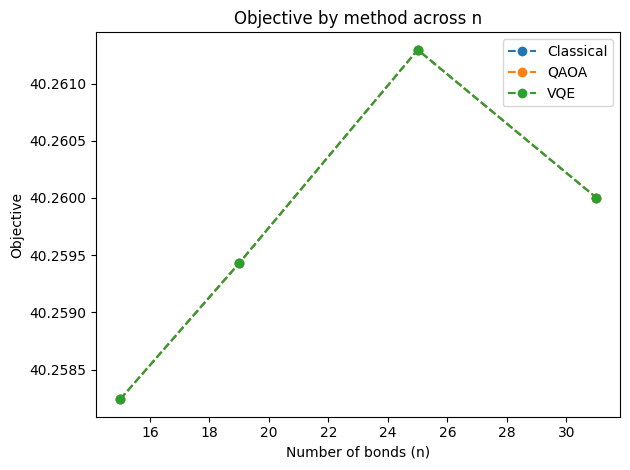

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure()
for m in ["Classical", "QAOA", "VQE"]:
    d = df[df["method"] == m].sort_values("n")
    plt.plot(d["n"], d["objective"], marker="o", linestyle='--', label=m)
plt.xlabel("Number of bonds (n)")
plt.ylabel("Objective")
plt.title("Objective by method across n")
plt.legend()
plt.tight_layout()
plt.show()


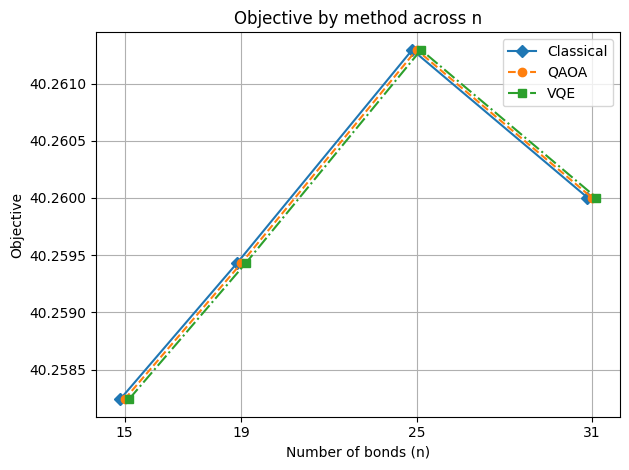

In [ ]:
methods = ["Classical","QAOA","VQE"]
styles  = {"Classical":("-", "D"), "QAOA":("--", "o"), "VQE":("-.", "s")}
offset  = {"Classical":-0.15, "QAOA":0.0, "VQE":+0.15}  # shifting just for clear visualization

plt.figure()
for m in methods:
    d = df[df["method"]==m].sort_values("n")
    x = d["n"] + offset[m]
    ls, mk = styles[m]
    plt.plot(x, d["objective"], linestyle=ls, marker=mk, label=m)
plt.xticks(sorted(df["n"].unique()))
plt.xlabel("Number of bonds (n)")
plt.ylabel("Objective")
plt.title("Objective by method across n")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Conclusion

The latest results show that both quantum routines (QAOA and VQE) achieved performance on par with the benchmark classical solution (docplex.lp) when evaluated under the same objective and constraint set. The objective values were comparable across all methods, demonstrating that the quantum formulations can produce solutions of similar quality to the established classical approach.